# Implementation

This section implements the linear regression algorithm from scratch.

In [2]:
r"""Linear Regression Class.

High-level module implementing linear regression with support for multiple
solvers and regularization.

Features:
    - Closed Form Solution
    - Batch Gradient Descent
    - Stochastic Gradient Descent

Supports L1 and L2 regularization.

NOTE:
    1. Regularization parameter `C` is only applicable when `regularization` is set.
    2. Ensure that input data does not contain NaN or infinite values.
"""

from __future__ import annotations

import functools
import logging
from typing import Any, Callable, List, Optional, TypeVar

import numpy as np
from numpy.typing import NDArray
from sklearn.exceptions import NotFittedError
from typing_extensions import Concatenate, ParamSpec

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


P = ParamSpec("P")
T = TypeVar("T")


def not_fitted(func: Callable[Concatenate[LinearRegression, P], T]) -> Callable[Concatenate[LinearRegression, P], T]:
    @functools.wraps(func)
    def wrapper(self: LinearRegression, *args: P.args, **kwargs: P.kwargs) -> T:
        if not self._fitted:
            raise NotFittedError
        else:
            return func(self, *args, **kwargs)

    return wrapper


class MyLinearRegression:
    """
    Linear Regression model supporting multiple solvers and regularization.

    Attributes
    ----------
    coef_ : NDArray[np.floating[Any]]
        Coefficient vector.
    intercept_ : float
        Intercept term.
    has_intercept : bool
        Whether to include an intercept in the model.
    solver : str
        Solver type: {"Closed Form Solution", "Batch Gradient Descent",
        "Stochastic Gradient Descent"}.
    learning_rate : float
        Learning rate for gradient descent solvers.
    loss_function : LossFunction
        Loss function to be minimized.
    regularization : Optional[str]
        Type of regularization: {"l1", "l2"} or None.
    C : Optional[float]
        Regularization strength. Must be a positive float.
    num_epochs : int
        Number of epochs for gradient descent solvers.
    _fitted : bool
        Flag indicating whether the model has been fitted.
    loss_history : List[float]
        History of loss values during training.
    optimal_betas : NDArray[np.floating[Any]]
        Optimal beta coefficients after fitting.
    """

    def __init__(
        self,
        has_intercept: bool = True,
        solver: str = "Closed Form Solution",
        learning_rate: float = 0.1,
        loss_function: Optional[Any] = None,
        regularization: Optional[str] = None,
        C: Optional[float] = None,
        num_epochs: Optional[int] = 1000,
    ) -> None:
        """
        Initialize the Linear Regression model with specified parameters.

        Parameters
        ----------
        has_intercept : bool, default=True
            Whether to include an intercept in the model.
        solver : str, default="Closed Form Solution"
            Solver type: {"Closed Form Solution", "Batch Gradient Descent", "Stochastic Gradient Descent"}.
        learning_rate : float, default=0.01
            Learning rate for gradient descent solvers.
        loss_function : LossFunction, default=LossFunction.l2_loss()
            Loss function to be minimized.
        regularization : Optional[str], default=None
            Type of regularization: {"l1", "l2"} or None.
        C : Optional[float], default=None
            Regularization strength. Must be a positive float.
        num_epochs : int, default=1000
            Number of epochs for gradient descent solvers.
        """
        self.solver = solver
        self.has_intercept = has_intercept
        self.learning_rate = learning_rate
        self.loss_function = loss_function or self.l2_loss
        self.regularization = regularization
        self.C = C
        self.num_epochs = num_epochs

        self.coef_: NDArray[np.floating[Any]]
        self.intercept_: float | None = None
        self._fitted: bool = False
        self.optimal_betas: NDArray[np.floating[Any]]

        self.loss_history: List[float] = []

        # Validate regularization parameters
        if self.regularization is not None and self.C is None:
            raise ValueError("Regularization strength 'C' must be provided when using regularization.")

        if self.regularization not in {None, "l1", "l2"}:
            raise ValueError("Regularization must be one of {None, 'l1', 'l2'}.")

        # Validate solver
        valid_solvers = {"Closed Form Solution", "Batch Gradient Descent", "Stochastic Gradient Descent"}
        if self.solver not in valid_solvers:
            raise ValueError(f"Solver must be one of {valid_solvers}.")

    @staticmethod
    def l2_loss(y_true: NDArray[np.floating[Any]], y_pred: NDArray[np.floating[Any]]) -> float:
        return np.square(y_true - y_pred).mean()  # type: ignore[no-any-return]

    def _add_regularization(self, loss: float, w: NDArray[np.floating[Any]]) -> float:
        """
        Apply regularization to the loss.

        Parameters
        ----------
        loss : float
            Current loss value.
        w : NDArray[np.floating[Any]]
            Weight vector.

        Returns
        -------
        float
            Updated loss with regularization.
        """
        if self.regularization == "l1":
            loss += self.C * np.abs(w[1:]).sum()
        elif self.regularization == "l2":
            assert self.C is not None
            loss += (0.5 * self.C) * np.square(w[1:]).sum()
        return loss

    def _initialize_weights(self, n_features: int) -> NDArray[np.floating[Any]]:
        """
        Initialize weights for gradient descent solvers.

        Parameters
        ----------
        n_features : int
            Number of features.

        Returns
        -------
        NDArray[np.floating[Any]]
            Initialized weight vector.
        """
        return np.zeros((n_features, 1))

    def _check_input_shapes(
        self, X: NDArray[np.floating[Any]], y_true: NDArray[np.floating[Any]]
    ) -> tuple[NDArray[np.floating[Any]], NDArray[np.floating[Any]]]:
        """
        Validate and reshape input data.

        Parameters
        ----------
        X : NDArray[np.floating[Any]]
            Input feature matrix.
        y_true : NDArray[np.floating[Any]]
            True target values.

        Returns
        -------
        tuple[NDArray[np.floating[Any]], NDArray[np.floating[Any]]]
            Reshaped feature matrix and target vector.
        """
        if X.ndim == 1:
            X = X.reshape(-1, 1)
            logging.info("Reshaped X to 2D array with shape %s.", X.shape)

        if y_true.ndim == 1:
            y_true = y_true.reshape(-1, 1)
            logging.info("Reshaped y_true to 2D array with shape %s.", y_true.shape)

        if X.shape[0] != y_true.shape[0]:
            raise ValueError("Number of samples in X and y_true must be equal.")

        return X, y_true

    def fit(self, X: NDArray[np.floating[Any]], y_true: NDArray[np.floating[Any]]) -> LinearRegression:
        """
        Fit the Linear Regression model to the data.

        Parameters
        ----------
        X : NDArray[np.floating[Any]]
            Input feature matrix of shape (n_samples, n_features).
        y_true : NDArray[np.floating[Any]]
            True target values of shape (n_samples,).

        Returns
        -------
        LinearRegression
            The fitted model.
        """
        X, y_true = self._check_input_shapes(X, y_true)

        # Add intercept term if necessary
        if self.has_intercept:
            X = np.insert(X, 0, 1, axis=1)
            logging.info("Added intercept term to X.")

        n_samples, n_features = X.shape
        logging.info("Fitting model with %d samples and %d features.", n_samples, n_features)

        if self.solver == "Closed Form Solution":
            XtX = X.T @ X
            det = np.linalg.det(XtX)
            if det == 0:
                logging.warning("Singular matrix encountered. Using pseudo-inverse instead.")
                XtX_inv = np.linalg.pinv(XtX)
            else:
                XtX_inv = np.linalg.inv(XtX)
            Xty = X.T @ y_true
            self.optimal_betas = XtX_inv @ Xty
            logging.info("Computed optimal betas using Closed Form Solution.")

        elif self.solver in {"Batch Gradient Descent", "Stochastic Gradient Descent"}:
            assert self.num_epochs is not None
            self.optimal_betas = self._initialize_weights(n_features)
            logging.info("Initialized weights for Gradient Descent.")

            for epoch in range(1, self.num_epochs + 1):
                if self.solver == "Batch Gradient Descent":
                    y_pred = X @ self.optimal_betas
                elif self.solver == "Stochastic Gradient Descent":
                    indices = np.random.permutation(n_samples)  # noqa: NPY002
                    for i in indices:
                        xi = X[i].reshape(1, -1)
                        yi = y_true[i]
                        y_pred = xi @ self.optimal_betas
                        error = y_pred - yi
                        gradient = xi.T @ error
                        if self.regularization == "l2":
                            assert self.C is not None
                            gradient[1:] += self.C * self.optimal_betas[1:]
                        elif self.regularization == "l1":
                            gradient[1:] += self.C * np.sign(self.optimal_betas[1:])
                        self.optimal_betas -= self.learning_rate * gradient
                    continue  # Skip the rest of the loop for SGD

                error = y_pred - y_true
                loss = self.loss_function(y_true=y_true, y_pred=y_pred)
                loss = self._add_regularization(loss, self.optimal_betas)
                self.loss_history.append(loss)

                gradient = (2 / n_samples) * (X.T @ error)
                if self.regularization == "l2":
                    assert self.C is not None
                    gradient[1:] += self.C * self.optimal_betas[1:]
                elif self.regularization == "l1":
                    gradient[1:] += self.C * np.sign(self.optimal_betas[1:])

                self.optimal_betas -= self.learning_rate * gradient

                if epoch % 100 == 0 or epoch == 1:
                    logging.info("Epoch %d | Loss: %.4f", epoch, loss)

        # Set coefficients and intercept
        if self.has_intercept:
            self.intercept_ = float(self.optimal_betas[0])
            self.coef_ = self.optimal_betas[1:].flatten()
            logging.info("Set intercept and coefficients.")
        else:
            self.coef_ = self.optimal_betas.flatten()
            self.intercept_ = 0.0
            logging.info("Set coefficients without intercept.")

        self._fitted = True
        logging.info("Model fitting complete.")

        return self

    @not_fitted
    def predict(self, X: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """
        Predict target values using the fitted model.

        Parameters
        ----------
        X : NDArray[np.floating[Any]]
            Input feature matrix of shape (n_samples, n_features).

        Returns
        -------
        NDArray[np.floating[Any]]
            Predicted target values of shape (n_samples,).
        """
        if self.has_intercept:
            X = np.insert(X, 0, 1, axis=1)

        assert self.optimal_betas is not None
        y_pred = X @ self.optimal_betas
        return y_pred.flatten()

    def residuals(self, X: NDArray[np.floating[Any]], y_true: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """
        Calculate residuals between true and predicted values.

        Parameters
        ----------
        X : NDArray[np.floating[Any]]
            Input feature matrix.
        y_true : NDArray[np.floating[Any]]
            True target values.

        Returns
        -------
        NDArray[np.floating[Any]]
            Residuals of shape (n_samples,).
        """
        y_pred = self.predict(X)
        residuals = y_true.flatten() - y_pred
        return residuals

    @not_fitted
    def score(self, X: NDArray[np.floating[Any]], y_true: NDArray[np.floating[Any]]) -> float:
        """
        Calculate the coefficient of determination R^2 of the prediction.

        Parameters
        ----------
        X : NDArray[np.floating[Any]]
            Input feature matrix.
        y_true : NDArray[np.floating[Any]]
            True target values.

        Returns
        -------
        float
            R^2 score.
        """
        y_pred = self.predict(X)
        ss_total = np.sum((y_true.flatten() - np.mean(y_true)) ** 2)
        ss_res = np.sum((y_true.flatten() - y_pred) ** 2)
        r2_score = 1 - (ss_res / ss_total)
        return float(r2_score)


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from rich.pretty import pprint


def regression_test(solver: str = "Closed Form Solution") -> None:
    np.random.seed(1930)
    X, y_true = make_regression(
        n_samples=10000, n_features=10, random_state=1930, coef=False
    )  # returns 2-d array of 1000 by 10
    x_train, x_val, y_train, y_val = train_test_split(X, y_true, test_size=0.3, random_state=1930)

    lr_SKLEARN = LinearRegression(fit_intercept=True).fit(x_train, y_train)
    lr_CUSTOM = MyLinearRegression(solver=solver, has_intercept=True, num_epochs=10000).fit(x_train, y_train)

    # Debugged, the intercept is the one with major difference why? Answer: https://stackoverflow.com/questions/66881829/implementation-of-linear-regression-closed-form-solution/66886954?noredirect=1#comment118259946_66886954

    pprint(lr_CUSTOM.intercept_)
    pprint(lr_SKLEARN.intercept_)
    pprint(lr_CUSTOM.coef_)
    pprint(lr_SKLEARN.coef_)

    pred_CUSTOM = lr_CUSTOM.predict(x_val)
    pred_SKLEARN = lr_SKLEARN.predict(x_val)
    print("First Value HN", pred_CUSTOM[0])
    print("First Value SKLEARN", pred_SKLEARN[0])
    print("HN MSE", mean_squared_error(y_val, pred_CUSTOM))
    print("SKLEARN MSE", mean_squared_error(y_val, pred_SKLEARN))

regression_test()


2024-09-29 14:27:17,957 - INFO - Reshaped y_true to 2D array with shape (7000, 1).
2024-09-29 14:27:17,977 - INFO - Added intercept term to X.
2024-09-29 14:27:18,043 - INFO - Fitting model with 7000 samples and 11 features.
2024-09-29 14:27:18,070 - INFO - Computed optimal betas using Closed Form Solution.
/var/folders/l2/jjqj299126j0gycr9kkkt9xm0000gn/T/ipykernel_68141/987029641.py:292: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.intercept_ = float(self.optimal_betas[0])
2024-09-29 14:27:18,071 - INFO - Set intercept and coefficients.
2024-09-29 14:27:18,071 - INFO - Model fitting complete.


-3.2902622092179315e-15

-8.93729534823251e-15

array([65.74652523, 19.51408752, 32.05245375, 50.32013901, 52.76364276,
│   │   4.69437951, 47.88858774, 69.03001556, 30.41026743,  3.47178546])

array([65.74652523, 19.51408752, 32.05245375, 50.32013901, 52.76364276,
│   │   4.69437951, 47.88858774, 69.03001556, 30.41026743,  3.47178546])

First Value HN 183.222001509455
First Value SKLEARN 183.22200150945596
HN MSE 1.317631501630165e-25
SKLEARN MSE 3.1767035436560316e-25


2024-09-29 14:28:20,867 - INFO - Reshaped y_true to 2D array with shape (422, 1).
2024-09-29 14:28:20,873 - INFO - Added intercept term to X.
2024-09-29 14:28:20,874 - INFO - Fitting model with 422 samples and 2 features.
2024-09-29 14:28:20,876 - INFO - Initialized weights for Gradient Descent.
2024-09-29 14:28:20,876 - INFO - Epoch 1 | Loss: 29468.6469
2024-09-29 14:28:20,879 - INFO - Epoch 100 | Loss: 5777.2529
2024-09-29 14:28:20,882 - INFO - Epoch 200 | Loss: 5619.4054
2024-09-29 14:28:20,883 - INFO - Epoch 300 | Loss: 5475.2313
2024-09-29 14:28:20,887 - INFO - Epoch 400 | Loss: 5343.5459
2024-09-29 14:28:20,894 - INFO - Epoch 500 | Loss: 5223.2675
2024-09-29 14:28:20,896 - INFO - Epoch 600 | Loss: 5113.4080
2024-09-29 14:28:20,900 - INFO - Epoch 700 | Loss: 5013.0648
2024-09-29 14:28:20,903 - INFO - Epoch 800 | Loss: 4921.4137
2024-09-29 14:28:20,904 - INFO - Epoch 900 | Loss: 4837.7017
2024-09-29 14:28:20,906 - INFO - Epoch 1000 | Loss: 4761.2411
2024-09-29 14:28:20,907 - INFO -

SKLEARN Coefficients: [938.23786125]
HONGNAN Coefficients: [892.45056539]
HN MSE 2604.751428467252
SKLEARN MSE 2548.072398725969
Coefficient of determination: 0.47


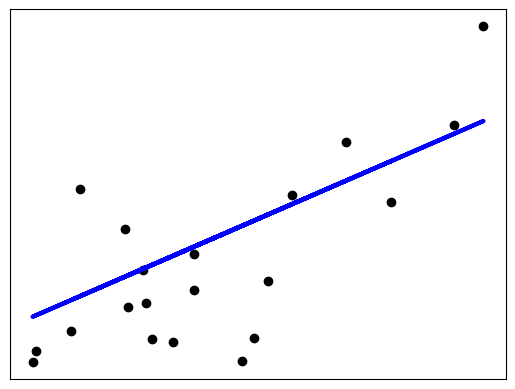

In [5]:
def regression_diabetes() -> None:
    diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

    # Use only one feature
    diabetes_X = diabetes_X[:, np.newaxis, 2]

    diabetes_X_train = diabetes_X[:-20]
    diabetes_X_test = diabetes_X[-20:]

    diabetes_y_train = diabetes_y[:-20]
    diabetes_y_test = diabetes_y[-20:]

    lr_SKLEARN = LinearRegression()
    lr_CUSTOM = MyLinearRegression(has_intercept=True, solver="Batch Gradient Descent", num_epochs=6666)

    lr_CUSTOM.fit(diabetes_X_train, diabetes_y_train)
    lr_SKLEARN.fit(diabetes_X_train, diabetes_y_train)

    # Make predictions using the testing set
    diabetes_y_pred = lr_SKLEARN.predict(diabetes_X_test)
    pred_CUSTOM = lr_CUSTOM.predict(diabetes_X_test)

    # The coefficients
    print("SKLEARN Coefficients:", lr_SKLEARN.coef_)
    print("HONGNAN Coefficients:", lr_CUSTOM.coef_)
    # The mean squared error
    print("HN MSE", mean_squared_error(diabetes_y_test, pred_CUSTOM))
    print("SKLEARN MSE", mean_squared_error(diabetes_y_test, diabetes_y_pred))

    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

    # Plot outputs
    plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
    plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

    plt.xticks(())
    plt.yticks(())

    plt.show()


regression_diabetes()
